In [50]:
import pandas as pd
import folium as fo
import selenium
import numpy as np
import datetime
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import json
pd.set_option('mode.chained_assignment', None)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.4', 'font.family':'Calibri'})

# Violation frequency  
## Violation frequency by violation category  
Regrouping violations in common categories will need less plots while maintening readability and finer analysis.  
To do so, we created 5 categories (food safety, hygiene, equipment, recidivism and others).  
For the analysis, we first map violation's id to their new category and then proceed as usual.

In [51]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
violation_category_mapping.head()

id
1    Food safety
2    Food safety
3    Food safety
4    Food safety
5        Hygiene
Name: category, dtype: object

We also restrict the analysis to certain types of facility: ie restaurants and grocery stores.  

In [417]:
inspections = pd.read_parquet('resources/cleaned_franchises.parquet').rename(columns={'Inspection Date': 'date', 'Nb Violations': 'nb_violations'})
inspections = inspections[inspections.date.apply(lambda x: x.year not in [2010, 2018, 2019])]
inspections.head()

DBA Name                  AKA Name  \
Inspection ID                                                             
2243951                     DONGPO IMPRESSION          DONGPOIMPRESSION   
2243933        LA MICHOACANA D BEATRIZ & ALMA  LAMICHOACANADBEATRIZALMA   
2243956                    DAIRY QUEEN BRAZER          DAIRYQUEENBRAZER   
2243939                     MINI CHI CHI INC.               SUPERCHICHI   
2243944              SU TAQUERIA THALY'S INC.          SUTAQUERIATHALYS   

               License # Facility Type    Risk                 Address    Zip  \
Inspection ID                                                                   
2243951          2551932    Restaurant    High        228 W CERMAK RD   60616   
2243933          2626768    Restaurant  Medium         6058 W 63RD ST   60638   
2243956            64537    Restaurant    High  5636 W IRVING PARK RD   60634   
2243939          2528322    Restaurant    High      5431 W MADISON ST   60644   
2243944          2559977    Restaurant    High      3156 N AUSTIN AVE   60634   

                    date Inspection Type Results  ... Re-inspection  \
Inspection ID                                     ...                 
2243951       2018-12-31       Complaint    Fail  ...         False   
2243933       2018-12-31         License    Fail  ...         False   
2243956       2018-12-31         Canvass    Pass  ...         False   
2243939       2018-12-31       Complaint    Fail  ...         False   
2243944       2018-12-31         Canvass    Pass  ...         False   

                    Community             Neighborhood  Ward Precinct  \
Inspection ID                                                           
2243951         ARMOUR SQUARE  ARMOUR SQUARE,CHINATOWN    25       14   
2243933              CLEARING           MIDWAY AIRPORT    13       11   
2243956          PORTAGE PARK             PORTAGE PARK    38       40   
2243939                AUSTIN                   AUSTIN    29       14   
2243944        BELMONT CRAGIN   BELMONT CRAGIN,HERMOSA    30       21   

                                                   Violation IDs  \
Inspection ID                                                      
2243951        [3, 5, 15, 37, 38, 38, 41, 43, 45, 47, 49, 55,...   
2243933                                                  [3, 10]   
2243956                                               [3, 5, 58]   
2243939                     [37, 38, 47, 47, 55, 55, 56, 60, 61]   
2243944                                       [3, 5, 47, 55, 58]   

              nb_violations Nb Violations of high severity  \
Inspection ID                                                
2243951                  17                              2   
2243933                   2                              2   
2243956                   3                              2   
2243939                   9                              0   
2243944                   5                              2   

              Nb Violations of medium severity  Nb Violations of low severity  
Inspection ID                                                                  
2243951                                      1                             14  
2243933                                      0                              0  
2243956                                      0                              1  
2243939                                      0                              9  
2243944                                      0                              3  

[5 rows x 23 columns]

In [418]:
categorized_violations = pd.read_parquet('resources/violations_oriented.parquet').rename(columns={'Violation ID': 'id', 'Inspection Date': 'date'})
categorized_violations.index = categorized_violations.date
categorized_violations['category'] = categorized_violations.id.map(lambda x: violation_category_mapping.get(x))

## Franchise oriented analysis

In [419]:
columns_rename = {'AKA Name': 'name', 'License #': 'license', 'Ward': 'ward', 'Violation IDs': 'violations', 'Inspection Date': 'date', 'Results': 'result', 'Risk': 'risk'}
columns_filter = columns_rename.values()
violations = pd.read_parquet('resources/cleaned_franchises.parquet').rename(columns=columns_rename)[columns_filter]
violations.date = violations.date.map(lambda x: x.year)
violations = violations[(violations.date > 2010) & (violations.date < 2018)]
violations.columns

Index(['name', 'license', 'ward', 'violations', 'date', 'result', 'risk'], dtype='object')

In [420]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique().tolist()
violation_categories.remove('Other')
'Violations categories are: ' + ' - '.join(violation_category_mapping.unique())

'Violations categories are: Food safety - Hygiene - Equipment - Recidivism - Other'

In [421]:
studied_franchises = ['SUBWAY', 'DUNKINDONUTS', 'MCDONALDS',\
                     'STARBUCKS', 'BURGERKING', 'POPEYES',\
                     'POTBELLYSANDWICH', 'CHIPOTLE', 'KFC',\
                     'HAROLDSCHICKEN', 'DOMINOS', 'WENDYS',\
                     'PIZZAHUT', 'AUBONPAIN', 'PAPAJOHNSPIZZA',\
                     'JAMBAJUICE', 'WINGSTOP', 'FRESHII',\
                     'JIMMYJOHNS', 'JJFISH',]
print('We are studying {} franchises.'.format(len(studied_franchises)))


We are studying 20 franchises.


## I] Franchises vs the rest of Chicago  
### 1] Average inspections per license 

In [422]:
licenses_per_name = violations[['name', 'license']].groupby(by='name').nunique()[['license']].rename(columns={'license': 'licenses'}).sort_values(by='licenses', ascending=False)
licenses_per_name.head()

licenses
name                  
SUBWAY             355
DUNKINDONUTS       240
STARBUCKS          212
MCDONALDS          153
BURGERKING         100

In [423]:
inspections_per_name = violations.copy()[['name']]
inspections_per_name['inspections'] = 1
inspections_per_name = inspections_per_name.groupby(by='name').count().sort_values(by='inspections', ascending=False)
inspections_per_name.head()

inspections
name                     
SUBWAY               2494
DUNKINDONUTS         1401
MCDONALDS            1157
STARBUCKS             854
BURGERKING            409

In [424]:
avg_inspections_per_license = licenses_per_name.join(inspections_per_name)
avg_inspections_per_license['rate'] = avg_inspections_per_license.inspections / avg_inspections_per_license.licenses
avg_inspections_per_license = avg_inspections_per_license.drop(['inspections', 'licenses'], axis=1)
avg_inspections_per_license['is_franchise'] = avg_inspections_per_license.index.isin(studied_franchises)
avg_inspections_per_license.is_franchise = avg_inspections_per_license.is_franchise.map(lambda x: 'Franchise' if x else 'Individual')

In [425]:
def is_franchise(x):
    if x in studied_franchises:
        return 'Franchise'
    elif franchise_size_dict[x] in ['Huge','Large']:
        return 'Franchise'
    elif franchise_size_dict[x] == 'Medium':
        return 'Small Franchise'
    else:
        return 'Individual'

franchise_size_dict = pd.read_pickle('resources/franchise_metadata.pkl')['Size'].to_dict()
avg_inspections_per_license['is_franchise'] = avg_inspections_per_license.index.map(is_franchise)

In [446]:
inspections.is_franchise.value_counts()

Individual         57086
Franchise          10775
Small Franchise     5684
Name: is_franchise, dtype: int64

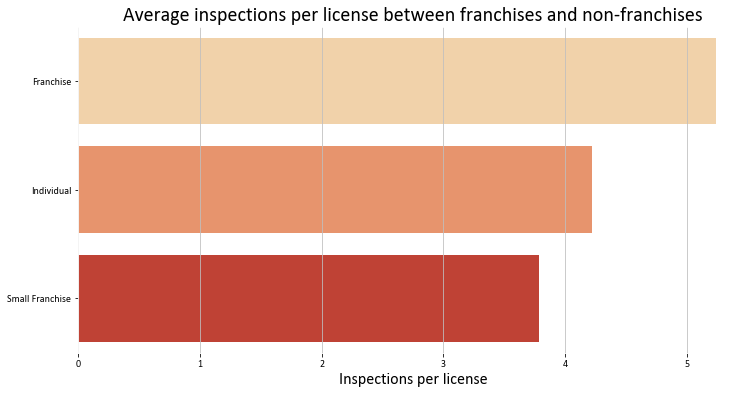

In [426]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 3))
bar = sns.barplot(x='rate', y='is_franchise', data=avg_inspections_per_license.groupby(by='is_franchise').mean().reset_index(), ax=ax)
bar.set_title('Average inspections per license between franchises and non-franchises', fontsize=20)
bar.set_xlabel("Inspections per license", fontsize=16)
bar.set_ylabel('', fontsize=16)
bar.grid(axis='x')

fig.savefig('results/figures_frequencies/inspections_avg_franchise_individuals.png')

Franchises are more inspected :)

### 2] Failed inspections

In [428]:
passed_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Results': 'result', 'Inspection Date': 'date'})[['name', 'result', 'date']]
passed_inspections.date = passed_inspections.date.map(lambda x: x.year)
passed_inspections = passed_inspections[(passed_inspections.date > 2010) & (passed_inspections.date < 2018)]
passed_inspections.name = passed_inspections.name.apply(is_franchise)
passed_inspections.result = passed_inspections.result.isin(['Fail'])
passed_inspections_rate = passed_inspections.groupby(by=['name', 'date']).mean()
passed_inspections_rate.result = passed_inspections_rate.result * 100
passed_inspections_rate.head()

result
name      date           
Franchise 2011  17.053643
          2012  18.067227
          2013  15.458580
          2014  18.436482
          2015  20.810056

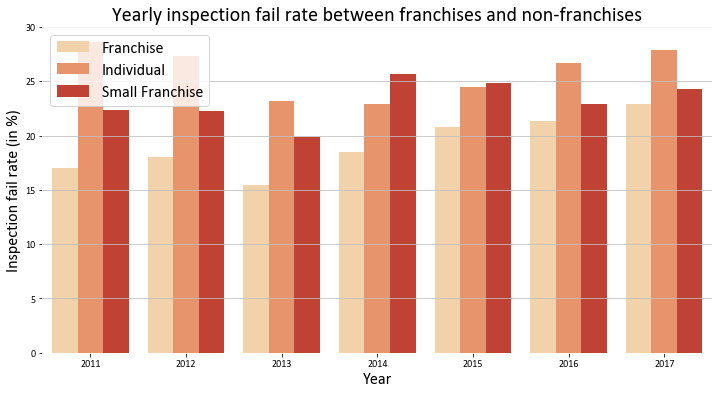

In [429]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 3))
bar = sns.barplot(x='date', y='result', hue='name', data=passed_inspections_rate.reset_index(), ax=ax)
bar.set_title('Yearly inspection fail rate between franchises and non-franchises', fontsize=20)
bar.legend(fontsize=16).set_title("")
bar.set_xlabel("Year", fontsize=16)
bar.set_ylabel('Inspection fail rate (in %)', fontsize=16)
bar.grid(axis='y')

fig.savefig('results/figures_frequencies/fail_rate.png')

### 3] Mean number of violations

In [430]:
passed_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Inspection Date': 'date'})[['name', 'nb_violations', 'date']]
passed_inspections.date = passed_inspections.date.map(lambda x: x.year)
passed_inspections = passed_inspections[(passed_inspections.date > 2010) & (passed_inspections.date < 2018)]
passed_inspections.name = passed_inspections.name.apply(is_franchise)
passed_inspections_rate = passed_inspections.groupby(by=['name', 'date']).mean()
passed_inspections_rate.head()

nb_violations
name      date               
Franchise 2011       3.256205
          2012       3.252941
          2013       2.932692
          2014       3.070358
          2015       3.265363

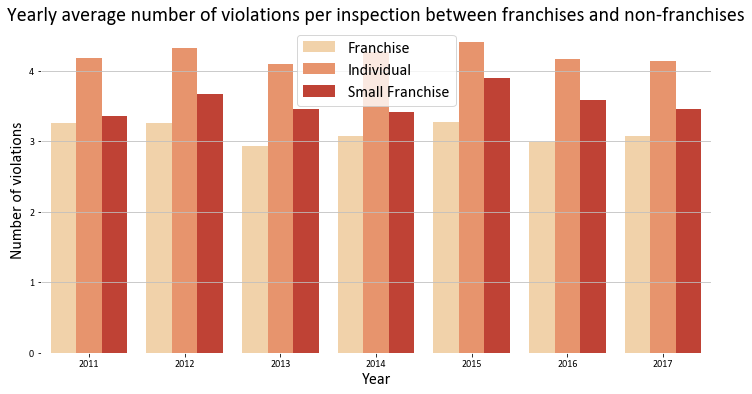

In [431]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 3))

bar = sns.barplot(x='date', y='nb_violations', hue='name', data=passed_inspections_rate.reset_index(), ax=ax)
bar.set_title('Yearly average number of violations per inspection between franchises and non-franchises', fontsize=20)
bar.legend(fontsize=16).set_title("")
bar.set_xlabel("Year", fontsize=16)
bar.set_ylabel('Number of violations', fontsize=16)
bar.grid(axis='y')

fig.savefig('results/figures_frequencies/nb_violations.png')

### 4] Average types of inspections

In [432]:
type_of_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Inspection Date': 'date', 'Inspection Type': 'type'})[['name', 'type', 'date']]
type_of_inspections.date = type_of_inspections.date.map(lambda x: x.year)
type_of_inspections = type_of_inspections[(type_of_inspections.date > 2010) & (type_of_inspections.date < 2018)]
type_of_inspections.name = type_of_inspections.name.apply(is_franchise)
type_of_inspections['count'] = 1

total_inspections = type_of_inspections.drop('type', axis=1).groupby(['name', 'date']).sum()
type_of_inspections_count = type_of_inspections.groupby(by=['name', 'date', 'type']).sum()

type_of_inspection_rate = total_inspections.join(type_of_inspections_count, lsuffix='_total')
type_of_inspection_rate['rate'] = 100 * type_of_inspection_rate['count'] / type_of_inspection_rate['count_total']
type_of_inspection_rate = type_of_inspection_rate.drop(['count_total', 'count'], axis=1).reset_index()
type_of_inspection_rate.head()

name  date          type       rate
0  Franchise  2011       Canvass  45.796637
1  Franchise  2011     Complaint  41.232986
2  Franchise  2011  Consultation   0.560448
3  Franchise  2011       License   7.766213
4  Franchise  2011        Others   2.722178

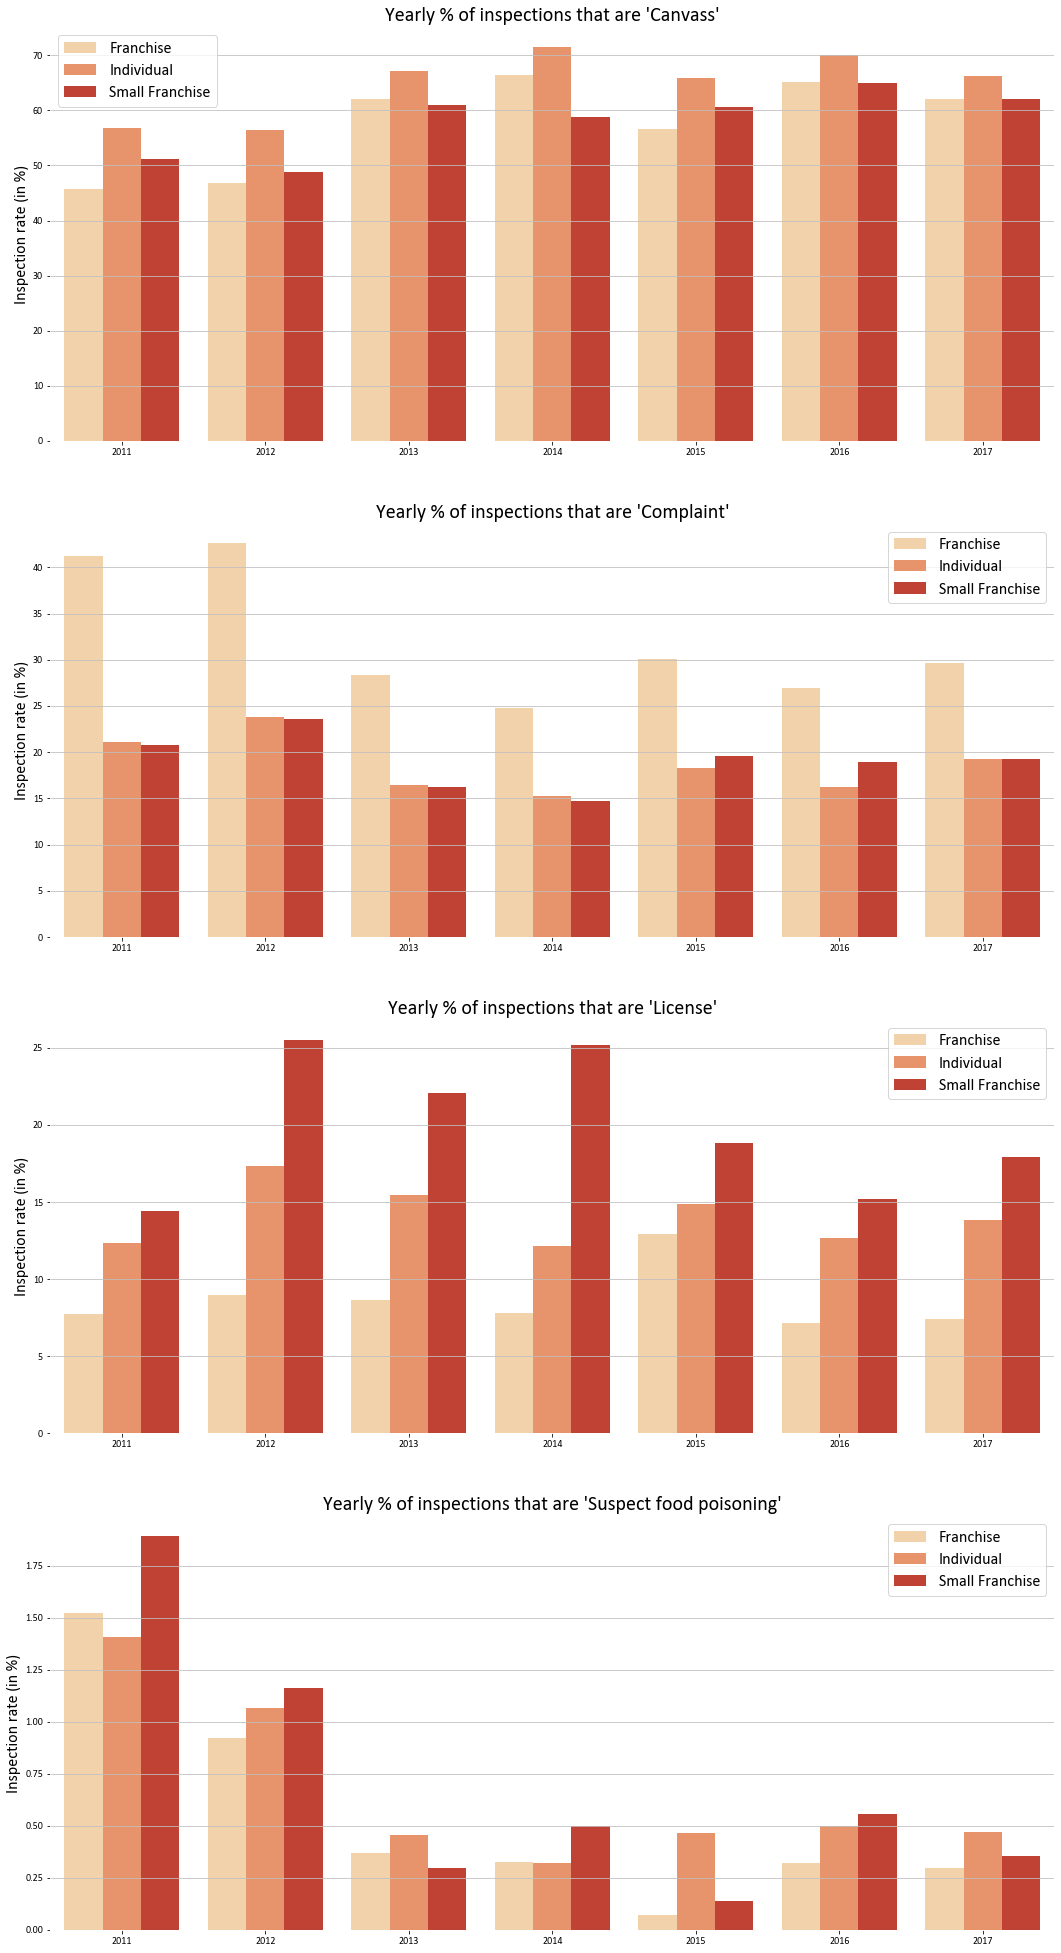

In [433]:
types = ['Canvass', 'Complaint', 'License', 'Suspect food poisoning']
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,35))
sns.set_palette(sns.color_palette("OrRd", 3))

for i, t in enumerate(types):
    filtered = type_of_inspection_rate[type_of_inspection_rate.type == t]
    bar = sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[i])
    bar.set_title('Yearly % of inspections that are \'{}\''.format(t), fontsize=20)
    bar.legend(fontsize=16).set_title("")
    bar.set_xlabel("")
    bar.set_ylabel('Inspection rate (in %)', fontsize=16)
    bar.grid(axis='y')
    
fig.savefig('results/figures_frequencies/inspection_types.png')

### 5] Types of inspections fail rate

### 6] Violations categories periodicity

In [482]:
exploded_violations = violations.explode('violations')
exploded_violations = exploded_violations[exploded_violations.violations != 'None']
exploded_violations.violations = exploded_violations.violations.astype('int32').map(lambda x: violation_category_mapping.get(x))
exploded_violations['is_franchise'] = exploded_violations.name.apply(is_franchise)
exploded_violations.head(5)

name  license ward   violations  date result  risk is_franchise
Inspection ID                                                                 
58528          GOSU  2074097    1  Food safety  2011   Fail  High   Individual
58528          GOSU  2074097    1      Hygiene  2011   Fail  High   Individual
58528          GOSU  2074097    1        Other  2011   Fail  High   Individual
58528          GOSU  2074097    1      Hygiene  2011   Fail  High   Individual
58528          GOSU  2074097    1    Equipment  2011   Fail  High   Individual

In [483]:
violation_categories_periodicity = exploded_violations.copy()
violation_categories_periodicity = violation_categories_periodicity[['is_franchise', 'violations', 'date']]
violation_categories_periodicity['v_count'] = 1
violation_categories_periodicity = violation_categories_periodicity.groupby(by=['is_franchise', 'violations', 'date']).sum().reset_index()
violation_categories_periodicity.head()

is_franchise violations  date  v_count
0    Franchise  Equipment  2011     1361
1    Franchise  Equipment  2012     1228
2    Franchise  Equipment  2013     1266
3    Franchise  Equipment  2014     1389
4    Franchise  Equipment  2015     1317

We want to normalize this count by the number of inspections.

In [484]:
inspections_per_day_and_franchise = violations.copy()[['name', 'date']]
inspections_per_day_and_franchise['is_franchise'] = inspections_per_day_and_franchise.name.apply(is_franchise)
inspections_per_day_and_franchise = inspections_per_day_and_franchise.drop('name', axis=1)
inspections_per_day_and_franchise['i_count'] = 1
inspections_per_day_and_franchise = inspections_per_day_and_franchise.groupby(by=['is_franchise', 'date']).sum()
inspections_per_day_and_franchise.head()

i_count
is_franchise date         
Franchise    2011     1249
             2012     1190
             2013     1352
             2014     1535
             2015     1432

In [485]:
category_rate = inspections_per_day_and_franchise.merge(violation_categories_periodicity, left_on=['is_franchise', 'date'], right_on=['is_franchise', 'date']).rename(columns={'violations': 'category'})
category_rate['rate'] = category_rate.v_count / category_rate.i_count
category_rate = category_rate.drop(['i_count', 'v_count'], axis=1)
category_rate.head()

is_franchise  date     category      rate
0    Franchise  2011    Equipment  1.089672
1    Franchise  2011  Food safety  0.148118
2    Franchise  2011      Hygiene  1.871898
3    Franchise  2011        Other  0.128102
4    Franchise  2011   Recidivism  0.018415

Overall, franchises have around +50% food safety violations, -25% equipment violations and more than about 2 to 5 times the amount of recidivism violations compared to non franchise stores.  

While big franchises want to maximize profit by making the most possible sales, it has a high impact on the overall sanitization of the restaurant.  
The high recidivism is surely the result of big corporation not caring enough about inspections and willing to make more profit while not caring about overall safety.

## I-A) socio-economical correlation

In [440]:
inspections['is_franchise'] = inspections['AKA Name'].apply(is_franchise)
inspections.head(2)

DBA Name                  AKA Name  \
Inspection ID                                                             
2243951                     DONGPO IMPRESSION          DONGPOIMPRESSION   
2243933        LA MICHOACANA D BEATRIZ & ALMA  LAMICHOACANADBEATRIZALMA   

               License # Facility Type    Risk           Address    Zip  \
Inspection ID                                                             
2243951          2551932    Restaurant    High  228 W CERMAK RD   60616   
2243933          2626768    Restaurant  Medium   6058 W 63RD ST   60638   

                    date Inspection Type Results  ...      Community  \
Inspection ID                                     ...                  
2243951       2018-12-31       Complaint    Fail  ...  ARMOUR SQUARE   
2243933       2018-12-31         License    Fail  ...       CLEARING   

                          Neighborhood  Ward  Precinct  \
Inspection ID                                            
2243951        ARMOUR SQUARE,CHINATOWN    25        14   
2243933                 MIDWAY AIRPORT    13        11   

                                                   Violation IDs  \
Inspection ID                                                      
2243951        [3, 5, 15, 37, 38, 38, 41, 43, 45, 47, 49, 55,...   
2243933                                                  [3, 10]   

              nb_violations Nb Violations of high severity  \
Inspection ID                                                
2243951                  17                              2   
2243933                   2                              2   

              Nb Violations of medium severity Nb Violations of low severity  \
Inspection ID                                                                  
2243951                                      1                            14   
2243933                                      0                             0   

               is_franchise  
Inspection ID                
2243951          Individual  
2243933          Individual  

[2 rows x 24 columns]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


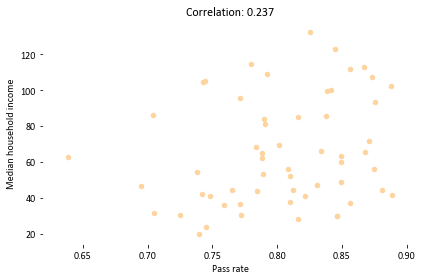

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Correlation between median household income and inspection pass rate for Franchise


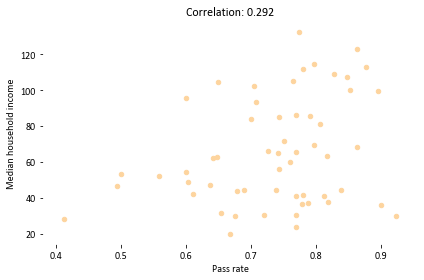

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Correlation between median household income and inspection pass rate for Small Franchise


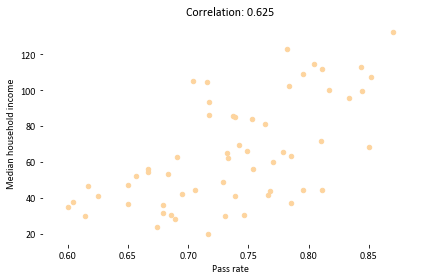

Correlation between median household income and inspection pass rate for Individual


In [441]:
df_zip_codes= pd.read_parquet('resources/zip_infos.parquet')

def corr_per_zip(df):
    df_joined = df.join(df_zip_codes)
    median_income = df_zip_codes.columns[1]
    data_ = df.columns[0]

    df_joined[[data_, median_income]].plot.scatter(x=data_, y=median_income)
    plt.title('Correlation: {}'.format("%.3f" % df_joined[data_].corr(df_joined[median_income])))
    plt.tight_layout()
    plt.show()

pass_rate_zip = inspections[['AKA Name','License #','Zip','Results','is_franchise']].rename(columns={'AKA Name':'name'})

for i, f in enumerate(['Franchise','Small Franchise','Individual']):
    try:
        df = pass_rate_zip[pass_rate_zip.is_franchise == f]
        df_pass = df[df.Results == 'Pass']
        df_pass_rate = pd.DataFrame(df_pass.groupby('Zip').size()/ \
                                       df.groupby('Zip').size()).rename(columns={0:'Pass rate'})
        corr_per_zip(df_pass_rate)

        print('Correlation between median household income and inspection pass rate for {0}'.format(f))
    except:
        pass

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


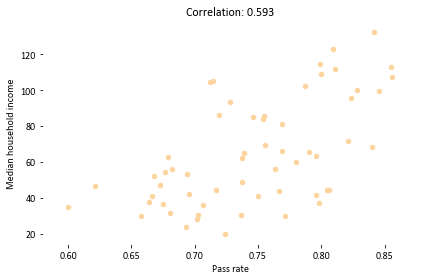

Correlation between median household income and inspection pass rate for Individual


In [445]:
df = pass_rate_zip
df_pass = df[df.Results == 'Pass']
df_pass_rate = pd.DataFrame(df_pass.groupby('Zip').size()/ \
                               df.groupby('Zip').size()).rename(columns={0:'Pass rate'})
corr_per_zip(df_pass_rate)

print('Correlation between median household income and inspection pass rate for {0}'.format(f))

In [443]:
franchise_metadata = pd.read_pickle('resources/franchise_metadata.pkl')['Size']
franchise_metadata.value_counts()

Small     11973
Medium      227
Large        17
Huge          5
Name: Size, dtype: int64

## II] Franchise groups vs each others  
This time, we will group every franchise in a group (ie: burgers, wraps, ...).  
This may reveal some interesting facts about different franchise types.

In [447]:
def franchise_map(franchise):
    if franchise in ['KFC', 'POPEYES', 'HAROLDSCHICKEN', 'WINGSTOP', 'JJFISH']: return 'Chicken/Fish'
    elif franchise in ['SUBWAY', 'POTBELLYSANDWICH', 'JIMMYJOHNS', 'AUBONPAIN']: return 'Sandwich'
    elif franchise in ['PIZZAHUT', 'DOMINOS', 'PAPAJOHNSPIZZA']: return 'Pizza'
    elif franchise in ['MCDONALDS', 'BURGERKING', 'WENDYS']: return 'Burger'
    elif franchise in ['JAMBAJUICE', 'STARBUCKS','DUNKINDONUTS']: return 'Drink'
    elif franchise in ['FRESHII','CHIPOTLE']: return 'Bowl/Burrito'
    return 'Other'

<Figure size 432x288 with 0 Axes>

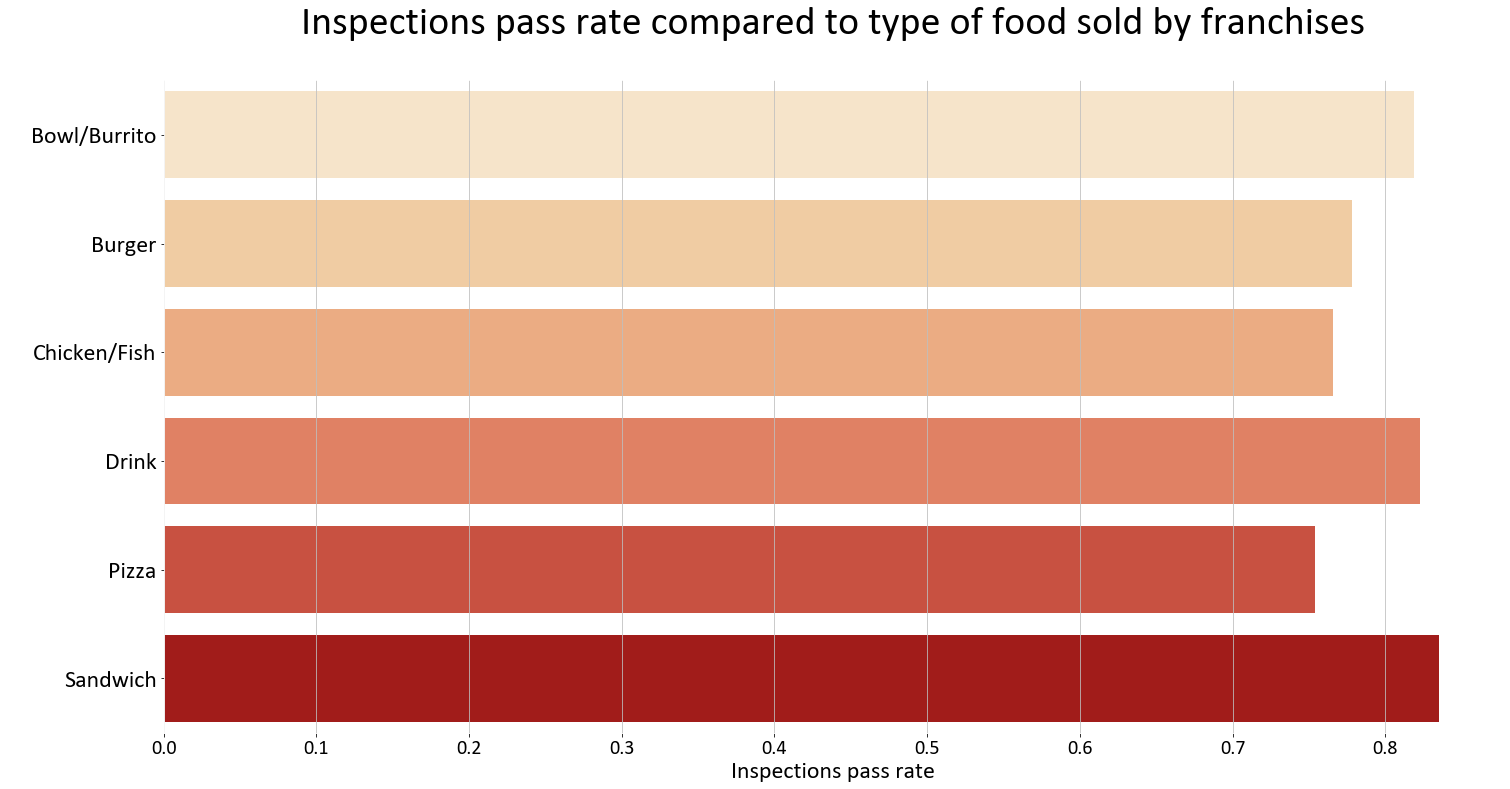

In [454]:
#average pass rate per each group

grouped_franchises_pass = inspections[(inspections['AKA Name'].isin(studied_franchises))].rename(columns={'AKA Name':'name'})
grouped_franchises_pass['year'] = grouped_franchises_pass.date.apply(lambda x: x.year)
grouped_franchises_pass.name = grouped_franchises_pass.name.apply(franchise_map)
grouped_franchises_pass_rate = pd.DataFrame(grouped_franchises_pass[grouped_franchises_pass.Results == 'Pass'].groupby(by='name').size() / \
                            grouped_franchises_pass.groupby(by='name').size()).rename(columns={0:'rate'}).reset_index(0)

sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.75', 'font.family':'Calibri'})

fig, ax = plt.subplots(figsize=(24, 12))

sns.set_palette(sns.color_palette("OrRd", 6))
bar = sns.barplot(x="rate", y="name", data=grouped_franchises_pass_rate,\
                  label="Total", ax=ax)
bar.set_title('Inspections pass rate compared to type of food sold by franchises\n', fontsize=40)
bar.set_xlabel('Inspections pass rate', fontsize=24)
bar.set_ylabel(' ', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)
bar.grid(axis='x')

In [457]:
'''grouped_franchises_pass_year = pd.DataFrame(grouped_franchises_pass[grouped_franchises_pass.Results=='Pass'].groupby(by=['name','year']).size()\
/ grouped_franchises_pass.groupby(by=['name','year']).size()).rename(columns={0:'rate'}).reset_index(0)'''

"grouped_franchises_pass_year = pd.DataFrame(grouped_franchises_pass[grouped_franchises_pass.Results=='Pass'].groupby(by=['name','year']).size()/ grouped_franchises_pass.groupby(by=['name','year']).size()).rename(columns={0:'rate'}).reset_index(0)"

<Figure size 432x288 with 0 Axes>

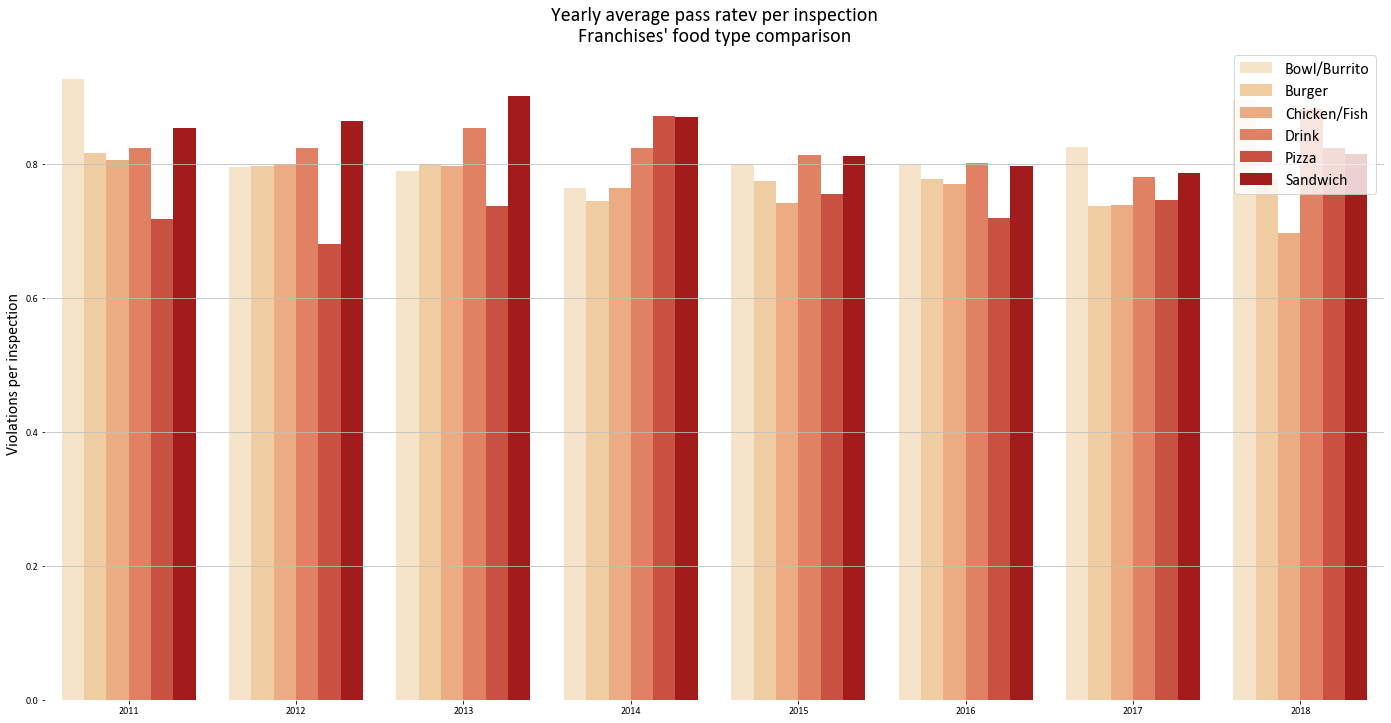

In [491]:
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.75', 'font.family':'Calibri'})

fig, ax = plt.subplots(figsize=(24, 12))
sns.set_palette(sns.color_palette("OrRd", 6))
filtered = grouped_franchises_pass_year

bar = sns.barplot(x='year', y='rate', hue='name', data=filtered[['year', 'name', 'rate']], ax=ax)
bar.set_title('Yearly average pass rate per inspection\nFranchises\' food type comparison', fontsize=20)
bar.legend(fontsize=16).set_title("")
axs[i].set_ylim(0, filtered.rate.values.max() * 1.25)
bar.set_xlabel("")
bar.set_ylabel('Violations per inspection', fontsize=16)
bar.grid(axis='y')
#axs[i].plot(filtered.date.values, filtered.rate)

### 1] Average inspections per license per group

In [493]:
grouped_franchises_licenses = licenses_per_name[licenses_per_name.index.isin(studied_franchises)]
grouped_franchises_licenses.index = grouped_franchises_licenses.index.map(franchise_map)
grouped_franchises_licenses = grouped_franchises_licenses.groupby(by='name').sum()

grouped_franchises_inspections = inspections_per_name[inspections_per_name.index.isin(studied_franchises)]
grouped_franchises_inspections.index = grouped_franchises_inspections.index.map(franchise_map)
grouped_franchises_inspections = grouped_franchises_inspections.groupby(by='name').sum()

inpections_per_license_per_inspection_group = grouped_franchises_licenses.join(grouped_franchises_inspections)
inpections_per_license_per_inspection_group['group'] = inpections_per_license_per_inspection_group.index
inpections_per_license_per_inspection_group['rate'] = inpections_per_license_per_inspection_group.inspections / inpections_per_license_per_inspection_group.licenses
inpections_per_license_per_inspection_group = inpections_per_license_per_inspection_group[inpections_per_license_per_inspection_group.group != 'Other']


<Figure size 432x288 with 0 Axes>

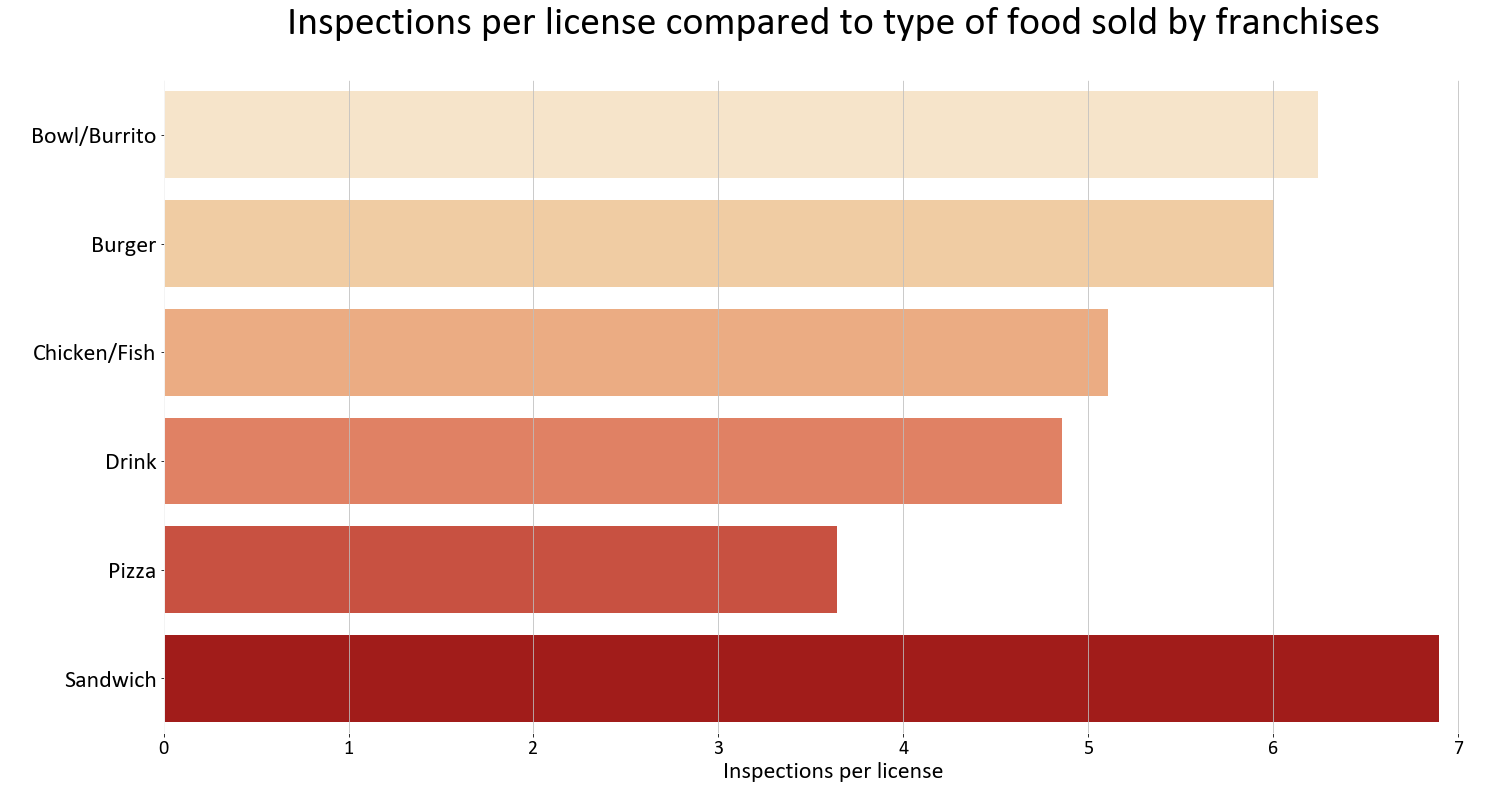

In [494]:
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.75', 'font.family':'Calibri'})

fig, ax = plt.subplots(figsize=(24, 12))

sns.set_palette(sns.color_palette("OrRd", 6))
bar = sns.barplot(x="rate", y="group", data=inpections_per_license_per_inspection_group,\
                  label="Total", ax=ax)
bar.set_title('Inspections per license compared to type of food sold by franchises\n', fontsize=40)
bar.set_xlabel('Inspections per license', fontsize=24)
bar.set_ylabel(' ', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)
bar.grid(axis='x')
fig.savefig('results/figures_frequencies/franchisetype_numberofviolations.png')

Clearly, two groups are more controlled than others: burger and sandwich fast foods.  
It contrast with pizza and coffee/milkshake place that are about 30% less inspected.

### 2] Violation average per group

In [460]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]

groups_inspections = franchises_inspections.copy()
groups_inspections.name = groups_inspections.name.map(franchise_map)
groups_inspections.head()

name  license ward       violations  date result    risk
Inspection ID                                                            
2129821         Drink  2398564   42             [37]  2017   Pass  Medium
2129808         Drink  2391841    5             [21]  2017   Pass  Medium
2114246        Burger  2368793   28             [38]  2017   Pass  Medium
2114244        Burger  2064662    4     [34, 35, 36]  2017   Pass  Medium
2129705        Burger  1984911   45  [6, 34, 35, 38]  2017   Pass  Medium

In [461]:
groups_violations = groups_inspections.explode('violations').rename(columns={'violations': 'id'})
groups_violations.head()

name  license ward  id  date result  risk
Inspection ID                                               
88637          Sandwich  1357930   49  30  2011   Pass  High
88637          Sandwich  1357930   49  33  2011   Pass  High
88637          Sandwich  1357930   49  34  2011   Pass  High
88637          Sandwich  1357930   49  35  2011   Pass  High
88642          Sandwich  2013950   39  18  2011   Fail  High

In [462]:
violations_per_group = groups_violations[['name', 'id', 'date']]
violations_per_group = violations_per_group[violations_per_group.id != 'None']
violations_per_group['category'] = violations_per_group.id.astype('int32').map(violation_category_mapping.get)
violations_per_group['v_count'] = 1
violations_per_group = violations_per_group.drop('id', axis=1)

violations_per_group_overall = violations_per_group.drop('date', axis=1).groupby(by=['name','category']).sum()
violations_per_group_overall.head()

v_count
name         category            
Bowl/Burrito Equipment        310
             Food safety      114
             Hygiene          622
             Other            113
             Recidivism        14

In [463]:
avg_violations_per_group_per_inspection = violations_per_group_overall.join(grouped_franchises_inspections)
avg_violations_per_group_per_inspection['rate'] = avg_violations_per_group_per_inspection.v_count / avg_violations_per_group_per_inspection.inspections
avg_violations_per_group_per_inspection = avg_violations_per_group_per_inspection.drop(['v_count', 'inspections'], axis=1)
avg_violations_per_group_per_inspection.head()

rate
name         category             
Bowl/Burrito Equipment    0.670996
             Food safety  0.246753
             Hygiene      1.346320
             Other        0.244589
             Recidivism   0.030303

In [464]:
avg_violations_per_group_per_inspection.reset_index().pivot(index='name', columns='category', values='rate')

category      Equipment  Food safety   Hygiene     Other  Recidivism
name                                                                
Bowl/Burrito   0.670996     0.246753  1.346320  0.244589    0.030303
Burger         1.090200     0.193764  2.038419  0.081849    0.031180
Chicken/Fish   1.120064     0.154714  2.253022  0.202256    0.050766
Drink          0.915876     0.160483  1.619068  0.163072    0.031061
Pizza          0.904282     0.110831  1.740554  0.307305    0.042821
Sandwich       0.839951     0.201908  1.509080  0.164358    0.033857

### 3] Violation periodicity per group

In [465]:
inspections_per_group_per_day = groups_inspections[['name', 'date']]
inspections_per_group_per_day['i_count'] = 1
inspections_per_group_per_day = inspections_per_group_per_day.groupby(by=['name', 'date']).sum()
inspections_per_group_per_day.head()

i_count
name         date         
Bowl/Burrito 2011       41
             2012       39
             2013       52
             2014       76
             2015       80

In [466]:
violations_per_group_per_day = violations_per_group.copy()
violations_per_group_per_day = violations_per_group_per_day.groupby(by=['name', 'category', 'date']).sum().reset_index('category')
violations_per_group_per_day.head()

category  v_count
name         date                    
Bowl/Burrito 2011  Equipment       22
             2012  Equipment       31
             2013  Equipment       39
             2014  Equipment       51
             2015  Equipment       48

In [467]:
category_rate_per_group = inspections_per_group_per_day.join(violations_per_group_per_day)
category_rate_per_group['rate'] = category_rate_per_group.v_count / category_rate_per_group.i_count
category_rate_per_group = category_rate_per_group.drop(['i_count', 'v_count'], axis=1).reset_index()
category_rate_per_group = category_rate_per_group[category_rate_per_group.name != 'Other']
category_rate_per_group.head()

name  date     category      rate
0  Bowl/Burrito  2011    Equipment  0.536585
1  Bowl/Burrito  2011  Food safety  0.170732
2  Bowl/Burrito  2011      Hygiene  1.073171
3  Bowl/Burrito  2011        Other  0.170732
4  Bowl/Burrito  2011   Recidivism  0.048780

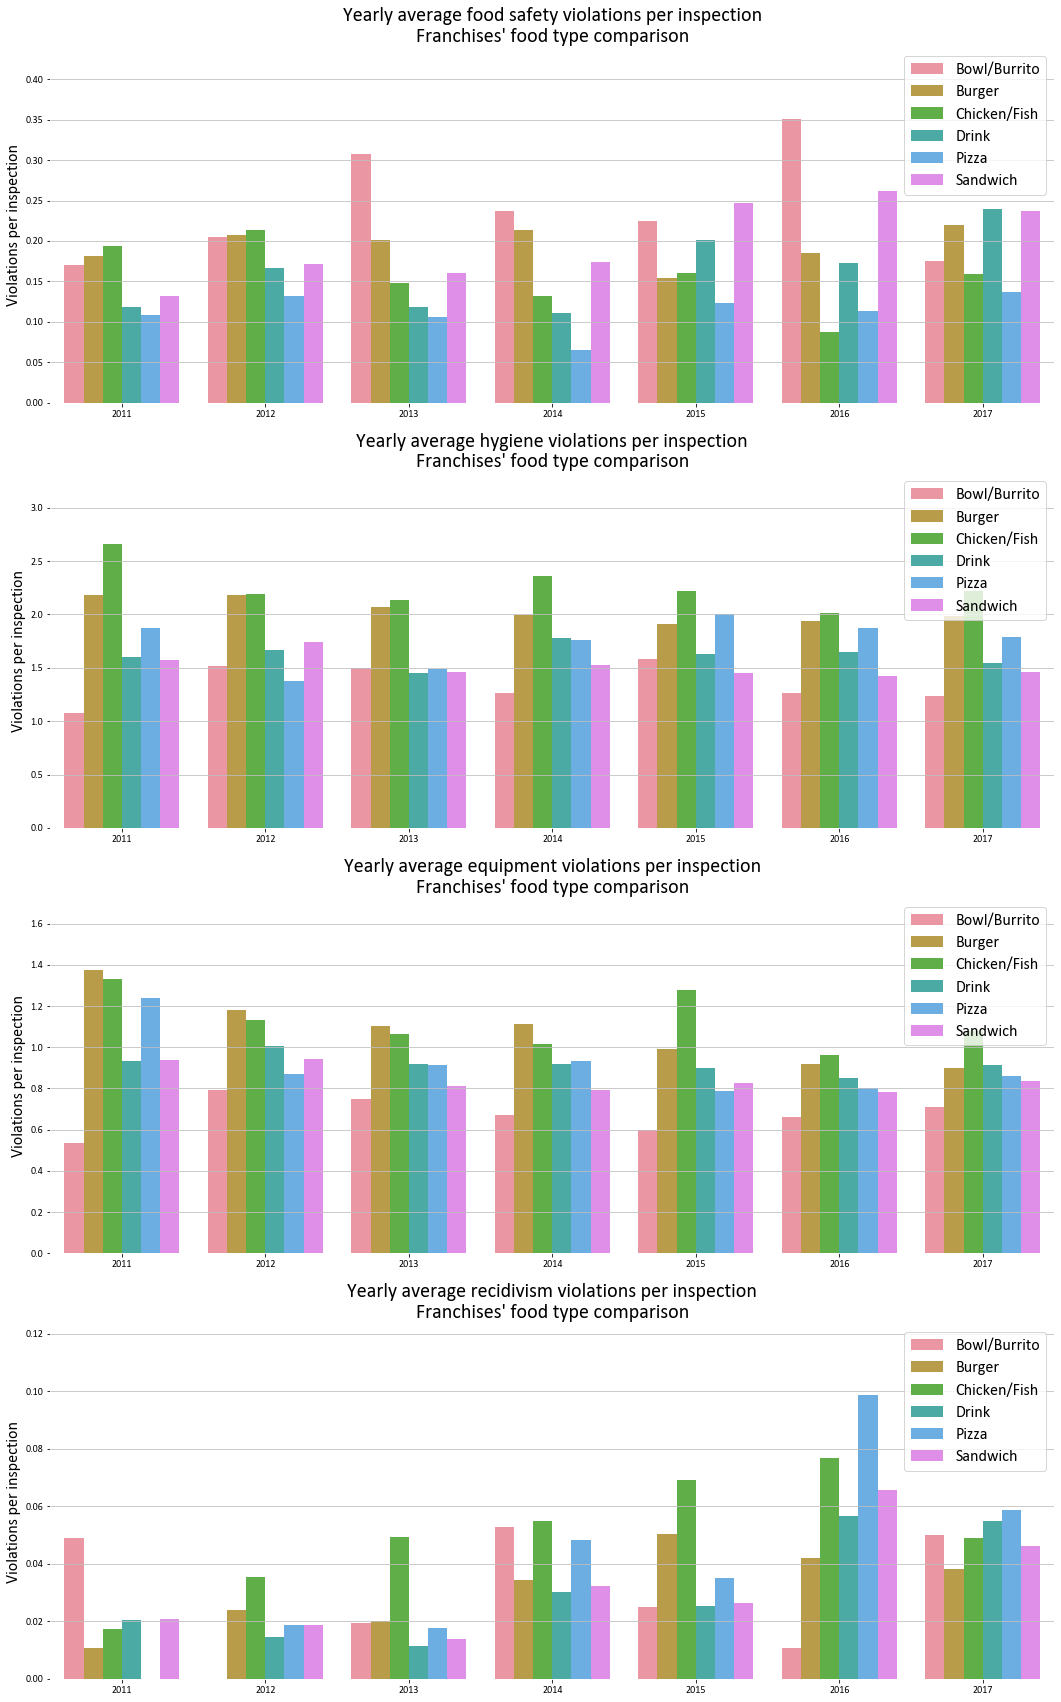

In [481]:
groups = category_rate_per_group.name.unique()
franchises = category_rate.is_franchise.unique()
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,30))
sns.set_palette(sns.color_palette("OrRd", 5))

for i, v_cat in enumerate(violation_categories):
    filtered = category_rate_per_group[category_rate_per_group.category == v_cat]
    bar = sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[i])
    bar.set_title('Yearly average {} violations per inspection\nFranchises\' food type comparison'.format(v_cat.lower()), fontsize=20)
    bar.legend(fontsize=16).set_title("")
    axs[i].set_ylim(0, filtered.rate.values.max() * 1.25)
    bar.set_xlabel("")
    bar.set_ylabel('Violations per inspection', fontsize=16)
    bar.grid(axis='y')
    #axs[i].plot(filtered.date.values, filtered.rate)

fig.savefig('results/figures_frequencies/franchises_types.png')

## II] Franchise group members vs each others

In [469]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]
franchises_inspections['group'] = franchises_inspections.name.map(franchise_map)

inspections_per_franchises = franchises_inspections[['name', 'group', 'date']]
inspections_per_franchises['i_count'] = 1
inspections_per_franchises = inspections_per_franchises.groupby(by=['name', 'group', 'date']).sum()
inspections_per_franchises.head()

i_count
name      group    date         
AUBONPAIN Sandwich 2011       21
                   2012       17
                   2013       25
                   2014       23
                   2015       19

In [470]:
violations_per_franchise = franchises_inspections.explode('violations')
violations_per_franchise = violations_per_franchise[violations_per_franchise.violations != 'None']
violations_per_franchise['category'] = violations_per_franchise.violations.astype('int32').map(violation_category_mapping.get)
violations_per_franchise = violations_per_franchise[['name', 'group', 'category', 'date']]
violations_per_franchise['v_count'] = 1
violations_per_franchise = violations_per_franchise.groupby(by=['name', 'group', 'category', 'date']).sum().reset_index('category')
violations_per_franchise.head()

category  v_count
name      group    date                    
AUBONPAIN Sandwich 2011  Equipment       16
                   2012  Equipment       18
                   2013  Equipment       24
                   2014  Equipment       12
                   2015  Equipment       13

In [471]:
merged = inspections_per_franchises.join(violations_per_franchise)
merged['rate'] = merged.v_count / merged.i_count
merged = merged.drop(['v_count', 'i_count'], axis = 1).reset_index()
merged.head(10)

name     group  date     category      rate
0  AUBONPAIN  Sandwich  2011    Equipment  0.761905
1  AUBONPAIN  Sandwich  2011  Food safety  0.095238
2  AUBONPAIN  Sandwich  2011      Hygiene  1.619048
3  AUBONPAIN  Sandwich  2012    Equipment  1.058824
4  AUBONPAIN  Sandwich  2012  Food safety  0.352941
5  AUBONPAIN  Sandwich  2012      Hygiene  2.235294
6  AUBONPAIN  Sandwich  2012        Other  0.117647
7  AUBONPAIN  Sandwich  2013    Equipment  0.960000
8  AUBONPAIN  Sandwich  2013  Food safety  0.120000
9  AUBONPAIN  Sandwich  2013      Hygiene  1.520000

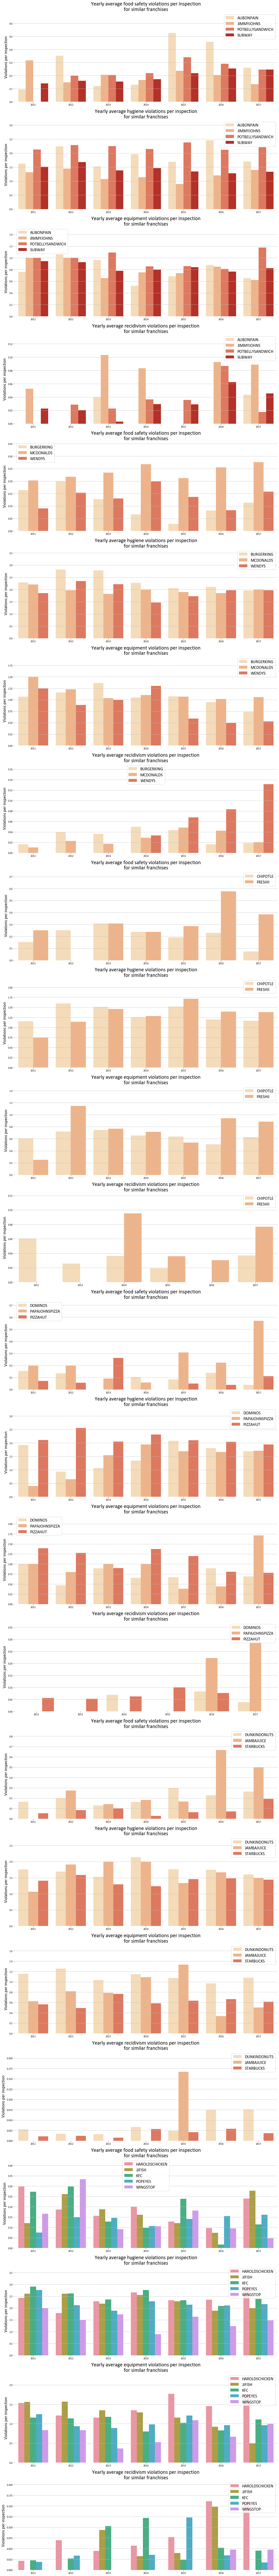

In [472]:
groups = merged.group.unique()
sns.set_palette(sns.color_palette("OrRd", 4))
names = []
for group in groups:
    names.append(merged[merged.group == group].name.unique())
    
fig, axs = plt.subplots(len(violation_categories) * len(groups), 1, figsize=(18,180))

for i, group in enumerate(groups):
    group_rate = merged[merged.group == group]
    
    for k, v_cat in enumerate(violation_categories):
        filtered = group_rate[group_rate.category == v_cat]
        bar = sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[k + i * len(violation_categories)])
        bar.set_title('Yearly average {} violations per inspection\nfor similar franchises'.format(v_cat.lower()), fontsize=20)
        bar.legend(fontsize=16).set_title("")
        bar.set_xlabel("")
        bar.set_ylabel('Violations per inspection', fontsize=16)
        axs[k + i * len(violation_categories)].set_ylim(0, filtered.rate.values.max() * 1.30)
        bar.grid(axis='y')
        #axs[i].plot(filtered.date.values, filtered.rate)
        
fig.savefig('results/figures_frequencies/in_groups_comparison.png')

## IV] Are franchises more concentrated in some areas?  

In [473]:
zips = set(pd.read_parquet('resources/zip_infos.parquet').index.astype('int32').astype('str').unique())

In [474]:
def fill_empty_zips(df):
    missing_zips = zips - set(df.index.values)
    missing_df = pd.DataFrame(missing_zips, columns=['zip'])
    missing_df['count'] = 0
    missing_df.index = missing_df.zip
    missing_df = missing_df[['count']]
    return df.append(missing_df)
    

def license_count_per_zip(franchise):
    licenses = inspections.copy()[inspections['AKA Name'] == franchise].rename(columns={'License #': 'license', 'Zip': 'zip'})
    licenses = licenses[['license', 'zip']].drop_duplicates()
    licenses.zip = licenses.zip.astype('str')
    licenses['count'] = 1
    return fill_empty_zips(licenses[['count', 'zip']].groupby(by=['zip']).sum())

In [475]:
def fail_rate_per_zip(franchise):
    licenses = inspections.copy()[inspections['AKA Name'] == franchise].rename(columns={'License #': 'license', 'Zip': 'zip', 'Results': 'result'})
    licenses = licenses[['zip', 'result']]
    licenses.zip = licenses.zip.astype('str')
    licenses['count'] = (licenses.result == 'Fail') * 100
    return licenses[['zip', 'count']].groupby(by=['zip']).mean()
    

In [476]:
def general_map(color, df, legend, bins=8):
    m = fo.Map(location=[41.8381136,-87.7297982], tiles='cartodbpositron', zoom_start=10, zoom_control=False, overlay=False, width=450, height=600)
    choropleth = fo.Choropleth(
        geo_data='resources/geojsons/chicago-zip.geojson',
        name=legend,
        data=df.reset_index(),
        columns=['zip', 'count'],
        nan_fill_color='grey',
        key_on='properties.zip',
        fill_color=color,
        bins=bins,
        fill_opacity=0.9,
        line_opacity=0.2,
        highlight=True,
        legend_name=legend,
        overlay=False
    )
    choropleth.add_to(m)
    return m

def count_map(franchise, color):
    df = license_count_per_zip(franchise)
    
    count_bins = [2*x for x in range(0,8)]
    if(df['count'].values.max() > max(count_bins)):
        count_bins.append(df['count'].values.max() + 1)
        
    return general_map(color, df, "Number of {}".format(franchise), count_bins)

def fail_map(franchise, color):
    df = fail_rate_per_zip(franchise)
    
    fail_rate_bins = [5*x for x in range(0,8)]
    if(df['count'].values.max() > max(fail_rate_bins)):
        fail_rate_bins.append(df['count'].values.max())
        
    return general_map(color, df, "Fail rate (in %) of {}".format(franchise), fail_rate_bins)

#### /!\ All other maps are in results/map.  
I didn't showed them here as it is mostly the same step as Harold's Chicken and it would make the notebook unreadable.

In [94]:
# 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'
count_map('WENDYS', 'Reds')

In [95]:
fail_map('WENDYS', 'Reds')

In [95]:
licenses = inspections.copy()[inspections['AKA Name'].apply(lambda x: franchise_size_dict[x] == 'Small')].rename(columns={'License #': 'license', 'Zip': 'zip', 'Results': 'result'})
licenses = licenses[['zip', 'result']]
licenses.zip = licenses.zip.astype('str')
licenses['count'] = (licenses.result == 'Fail') * 100
df = licenses[['zip', 'count']].groupby(by=['zip']).mean()

df.index
fail_rate_bins = [5*x for x in range(0,8)]
if(df['count'].values.max() > max(fail_rate_bins)):
    fail_rate_bins.append(df['count'].values.max())

general_map('Reds', df, "Fail rate (in %) of {}".format('small'), fail_rate_bins)